In [167]:
import pandas as pd
import cartopy.io.shapereader as shpreader
import pycountry
import geopandas as gpd
from shapely import wkt
import h3.api.numpy_int as h3

from tqdm import tqdm 

tqdm.pandas()

In [182]:
import stc_unicef_cpi.utils.geospatial as geo


In [6]:
dtypes = {'hex_code':int,
         'name_commuting':str}

In [9]:
data = pd.read_csv('../data/processed/20221021_hexes_ssf.csv', dtype=dtypes)
print(data.shape)

(4493068, 154)


In [328]:
temp = data['hex_code'].value_counts().reset_index()
# number of hexcode in multiple countries
repeating_hex = list(temp[temp.hex_code>1].iloc[:,0])
print(len(repeating_hex))
temp.head(6)

22637


,index,hex_code
0,609468834784477183,3
1,610055258294452223,3
2,609880557848887295,3
3,609535602919997439,3
4,609856790321954815,3
5,609561236543111167,3


In [273]:
pd.set_option('display.max_columns', 500)


In [329]:
repeating_df = data[data.hex_code.isin(repeating_hex)].copy()
repeating_df.head()

,hex_code,name_commuting,win_population_commuting,win_roads_km_commuting,area_commuting,n_conflicts,geometry,length_km,area_km2,road_density,avg_d_kbps,avg_u_kbps,GSM,LTE,UMTS,avg_signal,elevation,evapotrans,ndvi,ndwi,avg_rad,cf_cvg,pdsi,Optical_Depth_047,Optical_Depth_055,precimean,precistd,slope,2019gdp,africa,ec2019,GDP_PPP_1990,GDP_PPP_2000,GDP_PPP_2015,child_pop,rwi,rwi_error,survey,year,round,cluster,hhid,indid,location,sex,wealth,wealthscore,age,hhweight,sumpoor_sev,dep_housing_sev,dep_water_sev,dep_sanitation_sev,dep_nutrition_sev,dep_health_sev,dep_education_sev,deprived_sev,region,region2,latnum,longnum,dep_2_or_more_sev,dep_3_or_more_sev,dep_4_or_more_sev,hex_centroid,year_mean_neigh,round_mean_neigh,cluster_mean_neigh,hhid_mean_neigh,indid_mean_neigh,location_mean_neigh,sex_mean_neigh,wealth_mean_neigh,wealthscore_mean_neigh,age_mean_neigh,hhweight_mean_neigh,sumpoor_prev_neigh,sumpoor_count_neigh,housing_prev_neigh,housing_count_neigh,water_prev_neigh,water_count_neigh,sanitation_prev_neigh,sanitation_count_neigh,nutrition_prev_neigh,nutrition_count_neigh,health_prev_neigh,health_count_neigh,education_prev_neigh,education_count_neigh,deprived_sev_mean_neigh,deprived_sev_count_neigh,region_mean_neigh,region2_mean_neigh,latnum_mean_neigh,longnum_mean_neigh,2_or_more_prev_neigh,2_or_more_count_neigh,3_or_more_prev_neigh,3_or_more_count_neigh,4_or_more_prev_neigh,4_or_more_count_neigh,precipiacc,cnfd,accessibility,accessibility_walking_only,population,M_0,M_1,M_5,M_10,M_15,M_30,M_20,M_25,M_35,M_40,M_45,M_50,M_55,M_60,M_70,M_75,M_65,M_80,F_0,F_1,F_5,F_10,F_15,F_20,F_25,F_30,F_35,F_40,F_45,F_60,F_50,F_55,F_65,F_70,F_75,F_80,country_code,country,NR,CDMA,hex_code_str,water_surface,no_built,build_2000_2014,build_1990_2000,build_1975_1990,build_prior_1975
5,610274347042471935,cabinda,1.328792e+06,18139.152803,9605.344439,0.0,"((12.513643357654363, -4.606169102556799), (12...",0.000000,5.292866,0.000000,NaN,NaN,0.0,0.0,0.0,NaN,60.761906,728.647516,0.286226,0.277506,0.144754,3.010416,253.19048,347.931710,249.880583,0.128457,0.147494,5.682727,NaN,0.000134,NaN,NaN,NaN,NaN,0.261898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-4.598816087784532, 12.503453036254612)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,548.525440,0.000000,97.23240,299.5,0.546435,0.007985,0.033536,0.034960,0.033853,0.029235,0.017542,0.023795,0.022647,0.012697,0.010312,0.008245,0.008231,0.008730,0.004338,0.001716,0.000967,0.003918,0.000566,0.007998,0.033592,0.037420,0.036236,0.031292,0.028129,0.026772,0.020737,0.015009,0.012190,0.007588,0.003993,0.007576,0.008035,0.003605,0.001579,0.000890,0.000521,AGO,Angola,NaN,NaN,878214906ffffff,0,0,0,0,0,0
51,610276381732896767,cabinda,1.328792e+06,18139.152803,9605.344439,0.0,"((12.390501228296966, -4.714820264645121), (12...",0.000000,5.287771,0.000000,NaN,NaN,0.0,0.0,0.0,NaN,100.000000,725.408856,0.317175,0.273426,0.162103,3.187037,930.95240,411.309949,295.999463,0.132715,0.147433,6.706412,NaN,NaN,NaN,NaN,NaN,NaN,0.061982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-4.707459973958922, 12.380322831244824)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2040.927252,0.333333,233.98198,503.0,0.129322,0.001890,0.007937,0.008274,0.008012,0.006919,0.004151,0.005631,0.005360,0.003005,0.002441,0.001951,0.001948,0.002066,0.001027,0.000406,0.000229,0.000927,0.000134,0.001893,0.007950,0.008856,0.008576,0.007406,0.006657,0.006336,0.004908,0.003552,0.002885,0.001796,0.000945,0.001793,0.001902,0.000853,0.000374,0.000211,0.000123,AGO,Angola,NaN,NaN,8782322c3ffffff,0,1,0,0,0,0
150,610276460367708159,cabinda,1.328792e+06,18139.152803,9605.344439,0.0,"((12.215055139409673, -4.7995585124531

In [331]:
ls

hexagons_at_boundary.csv  stc_unicef_cpi/  stc_unicef_cpi.egg-info/


In [330]:
repeating_df.to_csv('hexagons_at_boundary.csv', index=False)

## Geometry

In [275]:
from shapely.geometry import Polygon

In [276]:
repeating_df = geo.get_poly_boundary(repeating_df, 'hex_code')

In [277]:
countries = pd.DataFrame(repeating_df['country']).drop_duplicates()
print(countries.shape)

countries['geometry_country'] = countries['country'].progress_apply(lambda x: get_shape_for_ctry(x))

(42, 1)


100%|██████████| 42/42 [00:01<00:00, 31.07it/s]


In [278]:
repeating_df = pd.merge(repeating_df, countries, how='left', on='country')

In [279]:
repeating_df['inters'] = repeating_df.apply(lambda x: x['geometry'].intersection(x['geometry_country']), axis=1)

/home/marco/anaconda3/envs/marina/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1983: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


In [280]:
repeating_df['area_inters'] = repeating_df['inters'].apply(lambda x: geo.get_area_polygon(x))
repeating_df['area_hex'] = repeating_df['geometry'].apply(lambda x: geo.get_area_polygon(x))

In [284]:
repeating_df['perc_area'] = repeating_df.apply(lambda x: abs(x['area_inters']/x['area_hex']), axis=1)

AREA POLYGON NEED TO BE POSITIVEEE!!!

<AxesSubplot:>

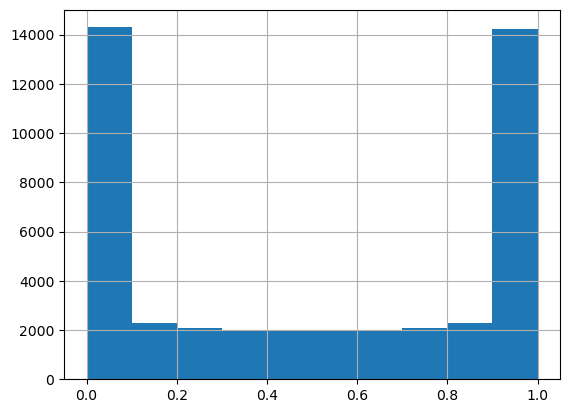

In [285]:
repeating_df['perc_area'].hist()

In [286]:
prova = repeating_df.groupby('hex_code')['perc_area'].sum()
prova.describe()

count    22637.000000
mean         0.998740
std          0.027625
min          0.004793
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000007
Name: perc_area, dtype: float64

In [287]:
sum(prova < 0.95)

67

## H3
The columns computed with the H3 library have the same ouput for each hex_code, so we drop the duplicates.

In [290]:
rep_df_agg = repeating_df[['hex_code', 'geometry', 'hex_centroid', 'hex_code_str'].drop_duplicates(subset=['hex_code'])
print(rep_df_agg.shape)
rep_df_agg.head(2)

(22637, 3)


,hex_code,geometry,hex_centroid
0,610274347042471935,POLYGON ((12.51364335765436 -4.606169102556799...,"(-4.598816087784532, 12.503453036254612)"
1,610276381732896767,POLYGON ((12.39050122829697 -4.714820264645121...,"(-4.707459973958922, 12.380322831244824)"


## Commuting zones

In [291]:
def only_one_country(df, subset):
    '''only one country has that info for that hex,
    so remove columns with na values and duplicates'''
    tmp = df.dropna(subset=subset, how='all')
    subset.append('hex_code')
    tmp = tmp[subset]
    tmp = tmp.drop_duplicates(subset=subset)
    return tmp


In [292]:
subset = ['name_commuting', 'win_population_commuting', 'win_roads_km_commuting', 'area_commuting']
tmp = only_one_country(repeating_df, subset)
print(tmp.shape)
print(tmp.hex_code.nunique())
tmp.head()
rep_df_agg = pd.merge(rep_df_agg, tmp, how='left', on = 'hex_code')

(18808, 5)
18808


## Conflict zones

Sum conflict zones

In [293]:
tmp = repeating_df.groupby('hex_code').agg({'n_conflicts':['sum', 'min', 'max']}).reset_index()
tmp[tmp['n_conflicts']['max'] != tmp['n_conflicts']['sum']].head()

hex_code n_conflicts           
                                 sum  min   max
5283  609540388939628543        14.0  6.0   8.0
5398  609540548088299519        17.0  1.0  16.0
5408  609540553691889663        28.0  4.0  24.0
8028  609852077316767743        12.0  6.0   6.0
8181  609852671481872383         2.0  1.0   1.0

In [294]:
cz = repeating_df.groupby('hex_code')['n_conflicts'].sum().reset_index()
rep_df_agg = pd.merge(rep_df_agg, cz, how='left', on = 'hex_code')
print(rep_df_agg.shape)
rep_df_agg.head(2)

(22637, 8)


,hex_code,geometry,hex_centroid,name_commuting,win_population_commuting,win_roads_km_commuting,area_commuting,n_conflicts
0,610274347042471935,POLYGON ((12.51364335765436 -4.606169102556799...,"(-4.598816087784532, 12.503453036254612)",cabinda,1.328792e+06,18139.152803,9605.344439,0.0
1,610276381732896767,POLYGON ((12.39050122829697 -4.714820264645121...,"(-4.707459973958922, 12.380322831244824)",cabinda,1.328792e+06,18139.152803,9605.344439,0.0


## Open Street Map


In [295]:
tmp = repeating_df[['hex_code', 'length_km', 'area_km2', 'road_density']].groupby('hex_code').agg({'area_km2':['sum', 'min', 'max']}).reset_index()
tmp[tmp['area_km2']['sum']!=tmp['area_km2']['max']].head(2)

hex_code area_km2        
                              sum min max
6969  609561237113536511      0.0 NaN NaN
8523  609854145947500543      0.0 NaN NaN

In [296]:
subset = ['length_km', 'area_km2', 'road_density']
osm = only_one_country(repeating_df, subset)
rep_df_agg = pd.merge(rep_df_agg, osm, how='left', on = 'hex_code')
print(rep_df_agg.shape)
rep_df_agg.head(2)


(22637, 11)


,hex_code,geometry,hex_centroid,name_commuting,win_population_commuting,win_roads_km_commuting,area_commuting,n_conflicts,length_km,area_km2,road_density
0,610274347042471935,POLYGON ((12.51364335765436 -4.606169102556799...,"(-4.598816087784532, 12.503453036254612)",cabinda,1.328792e+06,18139.152803,9605.344439,0.0,0.0,5.292866,0.0
1,610276381732896767,POLYGON ((12.39050122829697 -4.714820264645121...,"(-4.707459973958922, 12.380322831244824)",cabinda,1.328792e+06,18139.152803,9605.344439,0.0,0.0,5.287771,0.0


# Speed Test

In [298]:
speed = repeating_df[['hex_code', 'avg_d_kbps','avg_u_kbps', 'perc_area']].dropna(subset=['avg_d_kbps','avg_u_kbps'])
print(f'hexcode remaining after dropping nan: {speed.shape[0]}')
print(f'tmp unique: {speed.hex_code.nunique()}')

hexcode remaining after dropping nan: 184
tmp unique: 143


In [299]:
# weighted
speed['avg_d_kbps'] = speed['avg_d_kbps'] * speed['perc_area']
speed['avg_u_kbps'] = speed['avg_u_kbps'] * speed['perc_area']

speed = speed.groupby('hex_code').agg({'avg_d_kbps':'mean', 'avg_u_kbps':'mean'}).reset_index()
speed.head(2)

,hex_code,avg_d_kbps,avg_u_kbps
0,609463869248634879,11198.260393,3288.748209
1,609463940887347199,30279.930629,13026.043225


In [300]:
rep_df_agg = pd.merge(rep_df_agg, speed, how='left', on = 'hex_code')
print(rep_df_agg.shape)
rep_df_agg.head(2)

(22637, 17)


,hex_code,geometry,hex_centroid,name_commuting,win_population_commuting,win_roads_km_commuting,area_commuting,n_conflicts,length_km,area_km2,road_density,GSM,LTE,UMTS,CDMA,avg_d_kbps,avg_u_kbps
0,610274347042471935,POLYGON ((12.51364335765436 -4.606169102556799...,"(-4.598816087784532, 12.503453036254612)",cabinda,1.328792e+06,18139.152803,9605.344439,0.0,0.0,5.292866,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,610276381732896767,POLYGON ((12.39050122829697 -4.714820264645121...,"(-4.707459973958922, 12.380322831244824)",cabinda,1.328792e+06,18139.152803,9605.344439,0.0,0.0,5.287771,0.0,0.0,0.0,0.0,0.0,NaN,NaN


# Open cell id

Number of cell tower per type -- sum

In [309]:
cell = repeating_df.groupby('hex_code').agg({'GSM':'sum', 'LTE':'sum', 'UMTS':'sum', 'CDMA':'sum', 'NR':'sum'}).reset_index()
rep_df_agg = pd.merge(rep_df_agg, cell, how='left', on = 'hex_code')
print(rep_df_agg.shape)
rep_df_agg.head(2)

(22637, 97)


,hex_code,geometry,hex_centroid,name_commuting,win_population_commuting,win_roads_km_commuting,area_commuting,n_conflicts,length_km,area_km2,road_density,GSM_x,LTE_x,UMTS_x,CDMA_x,avg_d_kbps,avg_u_kbps,elevation_x,elevation_y,elevation_x,elevation_y,elevation_x,elevation_y,elevation_x,elevation_y,elevation_x,elevation_y,elevation_x,elevation_y,elevation_x,elevation_y,elevation_x,elevation_y,elevation,evapotrans,cnfd,accessibility,accessibility_walking_only,ndvi,ndwi,avg_rad,cf_cvg,pdsi,Optical_Depth_047,Optical_Depth_055,precipiacc,precimean,precistd,slope,population,M_0,M_1,M_5,M_10,M_15,M_20,M_25,M_30,M_35,M_40,M_45,M_60,M_50,M_55,M_65,M_70,M_75,M_80,F_0,F_1,F_5,F_10,F_15,F_20,F_25,F_30,F_35,F_40,F_45,F_60,F_50,F_55,F_65,F_70,F_75,F_80,2019gdp,africa,ec2019,GDP_PPP_1990,GDP_PPP_2000,GDP_PPP_2015,GSM_y,LTE_y,UMTS_y,CDMA_y,NR
0,610274347042471935,POLYGON ((12.51364335765436 -4.606169102556799...,"(-4.598816087784532, 12.503453036254612)",cabinda,1.328792e+06,18139.152803,9605.344439,0.0,0.0,5.292866,0.0,0.0,0.0,0.0,0.0,NaN,NaN,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,364.323758,0.000000,48.61620,149.75,0.143113,0.138753,0.072377,1.505208,126.59524,173.965855,124.940292,274.262720,0.064229,0.073747,2.841363,0.273217,0.003993,0.016768,0.017480,0.016927,0.014618,0.011898,0.011324,0.008771,0.006348,0.005156,0.004123,0.002169,0.004116,0.004365,0.001959,0.000858,0.000483,0.000283,0.003999,0.016796,0.018710,0.018118,0.015646,0.014065,0.013386,0.010368,0.007505,0.006095,0.003794,0.001996,0.003788,0.004017,0.001803,0.000790,0.000445,0.000260,NaN,0.000067,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1,610276381732896767,POLYGON ((12.39050122829697 -4.714820264645121...,"(-4.707459973958922, 12.380322831244824)",cabinda,1.328792e+06,18139.152803,9605.344439,0.0,0.0,5.287771,0.0,0.0,0.0,0.0,0.0,NaN,NaN,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,362.704428,0.166667,116.99099,251.50,0.158587,0.136713,0.081052,1.593519,465.47620,205.654974,147.999732,1020.463626,0.066357,0.073716,3.353206,0.064661,0.000945,0.003968,0.004137,0.004006,0.003459,0.002816,0.002680,0.002076,0.001502,0.001220,0.000976,0.000513,0.000974,0.001033,0.000464,0.000203,0.000114,0.000067,0.000946,0.003975,0.004428,0.004288,0.003703,0.003329,0.003168,0.002454,0.001776,0.001443,0.000898,0.000472,0.000896,0.000951,0.000427,0.000187,0.000105,0.000062,NaN,0.000000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0


## GEE

In [304]:
def weighted_agg(df, col, agg_fun = 'mean', col_weights = 'perc_area'):
    tmp = df.copy()
    tmp[col] = df[col] * df[col_weights]
    return tmp.groupby('hex_code')[col].agg(agg_fun).reset_index()


In [305]:
def aggregate(data, col, data_join, agg_fun = 'mean'):
    tmp = weighted_agg(repeating_df, col, agg_fun = 'mean', col_weights = 'perc_area')
    data_join = pd.merge(data_join, tmp, on ='hex_code')
    return data_join

In [306]:
rep_df_agg = aggregate(repeating_df, 'elevation', rep_df_agg, agg_fun = 'mean')
rep_df_agg = aggregate(repeating_df, 'evapotrans', rep_df_agg, agg_fun = 'mean')
rep_df_agg = aggregate(repeating_df, 'cnfd', rep_df_agg, agg_fun = 'mean')
rep_df_agg = aggregate(repeating_df, 'accessibility', rep_df_agg, agg_fun = 'median')
rep_df_agg = aggregate(repeating_df, 'accessibility_walking_only', rep_df_agg, agg_fun = 'median')
rep_df_agg = aggregate(repeating_df, 'ndvi', rep_df_agg, agg_fun = 'mean')
rep_df_agg = aggregate(repeating_df, 'ndwi', rep_df_agg, agg_fun = 'mean')
rep_df_agg = aggregate(repeating_df, 'avg_rad', rep_df_agg, agg_fun = 'mean')
rep_df_agg = aggregate(repeating_df, 'cf_cvg', rep_df_agg, agg_fun = 'mean')
rep_df_agg = aggregate(repeating_df, 'pdsi', rep_df_agg, agg_fun = 'mean')
rep_df_agg = aggregate(repeating_df, 'Optical_Depth_047', rep_df_agg, agg_fun = 'mean')
rep_df_agg = aggregate(repeating_df, 'Optical_Depth_055', rep_df_agg, agg_fun = 'mean')
rep_df_agg = aggregate(repeating_df, 'precipiacc', rep_df_agg, agg_fun = 'sum')
rep_df_agg = aggregate(repeating_df, 'precimean', rep_df_agg, agg_fun = 'mean')
rep_df_agg = aggregate(repeating_df, 'precistd', rep_df_agg, agg_fun = 'mean')
rep_df_agg = aggregate(repeating_df, 'slope', rep_df_agg, agg_fun = 'mean')

In [307]:
pop = ['population',
    'M_0', 'M_1', 'M_5', 'M_10', 'M_15', 'M_20', 'M_25', 'M_30', 'M_35', 'M_40', 'M_45', 'M_60', 'M_50', 'M_55', 'M_65', 'M_70', 'M_75', 'M_80',
    'F_0', 'F_1', 'F_5', 'F_10', 'F_15', 'F_20', 'F_25', 'F_30', 'F_35', 'F_40', 'F_45', 'F_60', 'F_50', 'F_55', 'F_65', 'F_70', 'F_75', 'F_80']

for col in pop:
    rep_df_agg = aggregate(repeating_df, col, rep_df_agg, agg_fun = 'sum')

In [ ]:
rep_df_agg['child_pop'] = rep_df_agg[['M_0', 'M_1', 'M_5','M_10', 'F_0', 'F_1', 'F_5','F_10']].sum(axis=1) + 0.6 * rep_df_agg[['M_15', 'F_15']].sum(axis=1)

## Economic

In [308]:
rep_df_agg = aggregate(repeating_df, '2019gdp', rep_df_agg, agg_fun = 'mean')
rep_df_agg = aggregate(repeating_df, 'africa', rep_df_agg, agg_fun = 'mean')
rep_df_agg = aggregate(repeating_df, 'ec2019', rep_df_agg, agg_fun = 'mean')
rep_df_agg = aggregate(repeating_df, 'GDP_PPP_1990', rep_df_agg, agg_fun = 'mean')
rep_df_agg = aggregate(repeating_df, 'GDP_PPP_2000', rep_df_agg, agg_fun = 'mean')
rep_df_agg = aggregate(repeating_df, 'GDP_PPP_2015', rep_df_agg, agg_fun = 'mean')

## RWI

In [310]:
rep_df_agg = aggregate(repeating_df, 'rwi', rep_df_agg, agg_fun = 'mean')
rep_df_agg = aggregate(repeating_df, 'rwi_error', rep_df_agg, agg_fun = 'mean')


In [311]:
print(rep_df_agg.shape)
rep_df_agg.head(2)

(22637, 99)


,hex_code,geometry,hex_centroid,name_commuting,win_population_commuting,win_roads_km_commuting,area_commuting,n_conflicts,length_km,area_km2,road_density,GSM_x,LTE_x,UMTS_x,CDMA_x,avg_d_kbps,avg_u_kbps,elevation_x,elevation_y,elevation_x,elevation_y,elevation_x,elevation_y,elevation_x,elevation_y,elevation_x,elevation_y,elevation_x,elevation_y,elevation_x,elevation_y,elevation_x,elevation_y,elevation,evapotrans,cnfd,accessibility,accessibility_walking_only,ndvi,ndwi,avg_rad,cf_cvg,pdsi,Optical_Depth_047,Optical_Depth_055,precipiacc,precimean,precistd,slope,population,M_0,M_1,M_5,M_10,M_15,M_20,M_25,M_30,M_35,M_40,M_45,M_60,M_50,M_55,M_65,M_70,M_75,M_80,F_0,F_1,F_5,F_10,F_15,F_20,F_25,F_30,F_35,F_40,F_45,F_60,F_50,F_55,F_65,F_70,F_75,F_80,2019gdp,africa,ec2019,GDP_PPP_1990,GDP_PPP_2000,GDP_PPP_2015,GSM_y,LTE_y,UMTS_y,CDMA_y,NR,rwi,rwi_error
0,610274347042471935,POLYGON ((12.51364335765436 -4.606169102556799...,"(-4.598816087784532, 12.503453036254612)",cabinda,1.328792e+06,18139.152803,9605.344439,0.0,0.0,5.292866,0.0,0.0,0.0,0.0,0.0,NaN,NaN,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,30.380953,364.323758,0.000000,48.61620,149.75,0.143113,0.138753,0.072377,1.505208,126.59524,173.965855,124.940292,274.262720,0.064229,0.073747,2.841363,0.273217,0.003993,0.016768,0.017480,0.016927,0.014618,0.011898,0.011324,0.008771,0.006348,0.005156,0.004123,0.002169,0.004116,0.004365,0.001959,0.000858,0.000483,0.000283,0.003999,0.016796,0.018710,0.018118,0.015646,0.014065,0.013386,0.010368,0.007505,0.006095,0.003794,0.001996,0.003788,0.004017,0.001803,0.000790,0.000445,0.000260,NaN,0.000067,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,610276381732896767,POLYGON ((12.39050122829697 -4.714820264645121...,"(-4.707459973958922, 12.380322831244824)",cabinda,1.328792e+06,18139.152803,9605.344439,0.0,0.0,5.287771,0.0,0.0,0.0,0.0,0.0,NaN,NaN,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,362.704428,0.166667,116.99099,251.50,0.158587,0.136713,0.081052,1.593519,465.47620,205.654974,147.999732,1020.463626,0.066357,0.073716,3.353206,0.064661,0.000945,0.003968,0.004137,0.004006,0.003459,0.002816,0.002680,0.002076,0.001502,0.001220,0.000976,0.000513,0.000974,0.001033,0.000464,0.000203,0.000114,0.000067,0.000946,0.003975,0.004428,0.004288,0.003703,0.003329,0.003168,0.002454,0.001776,0.001443,0.000898,0.000472,0.000896,0.000951,0.000427,0.000187,0.000105,0.000062,NaN,0.000000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN


## Country

In [320]:
# the hexcode belongs to the country where it belongs more
tmp = repeating_df[['hex_code', 'perc_area', 'country', 'country_code']].groupby('hex_code').max()
tmp.drop(columns=['perc_area'], inplace=True)
rep_df_agg = pd.merge(rep_df_agg, tmp, on='hex_code', how='left')
print(rep_df_agg.shape)
rep_df_agg.head(2)

## Built

In [ ]:
water_surface	no_built	build_2000_2014	build_1990_2000	build_1975_1990	build_prior_1975

## DHS

In [324]:
repeating_df.shape

(45304, 159)

In [323]:
sum(repeating_df['deprived_sev'].isna())

45171

In [327]:
repeating_df[repeating_df['deprived_sev'].isna()==False] ['country'].unique()

array(['Benin', 'Burkina Faso', 'Burundi', 'Cameroon',
       'Congo, The Democratic Republic of the', 'Guinea', 'Kenya',
       'Lesotho', 'Liberia', 'Malawi', 'Mali', 'Mozambique', 'Namibia',
       'Niger', 'Nigeria', 'Rwanda', 'Senegal', 'Sierra Leone',
       'Tanzania, United Republic of', 'Togo', 'Uganda', 'Zambia'],
      dtype=object)